In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict

# Load our data
popular_df = pd.read_csv("../data/games.csv")
sales_df = pd.read_csv("../data/vgsales.csv")
steam_df = pd.read_csv("../data/bestSelling_games.csv")


popular_df.head()
#sales_df.head()
#steam_df.head()

,Unnamed: 0,Title,Release Date,Team,Rating,Times Listed,Number of Reviews,Genres,Summary,Reviews,Plays,Playing,Backlogs,Wishlist
0,0,Elden Ring,"Feb 25, 2022","['Bandai Namco Entertainment', 'FromSoftware']",4.5,3.9K,3.9K,"['Adventure', 'RPG']","Elden Ring is a fantasy, action and open world...","[""The first playthrough of elden ring is one o...",17K,3.8K,4.6K,4.8K
1,1,Hades,"Dec 10, 2019",['Supergiant Games'],4.3,2.9K,2.9K,"['Adventure', 'Brawler', 'Indie', 'RPG']",A rogue-lite hack and slash dungeon crawler in...,['convinced this is a roguelike for people who...,21K,3.2K,6.3K,3.6K
2,2,The Legend of Zelda: Breath of the Wild,"Mar 03, 2017","['Nintendo', 'Nintendo EPD Production Group No...",4.4,4.3K,4.3K,"['Adventure', 'RPG']",The Legend of Zelda: Breath of the Wild is the...,['This game is the game (that is not CS:GO) th...,30K,2.5K,5K,2.6K
3,3,Undertale,"Sep 15, 2015","['tobyfox', '8-4']",4.2,3.5K,3.5K,"['Adventure', 'Indie', 'RPG', 'Turn Based Stra...","A small child falls into the Underground, wher...",['soundtrack is tied for #1 with nier automata...,28K,679,4.9K,1.8K
4,4,Hollow Knight,"Feb 24, 2017",['Team Cherry'],4.4,3K,3K,"['Adventure', 'Indie', 'Platform']",A 2D metroidvania with an emphasis on close co...,"[""this games worldbuilding is incredible, with...",21K,2.4K,8.3K,2.3K


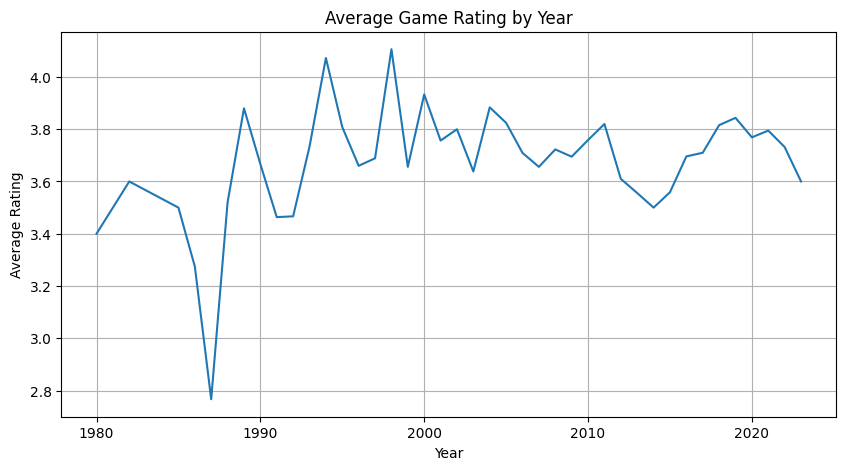

In [22]:
import matplotlib.pyplot as plt

# Convert the release dates to datetime format to use year
popular_df["Release Date"] = pd.to_datetime(popular_df["Release Date"], errors="coerce")
# Drop the rows where we can't get release date
popular_df = popular_df.dropna(subset=["Release Date"])
# Extract the year as a new column
popular_df["Year"] = popular_df["Release Date"].dt.year

# Plot the average game rating by year
popular_df.groupby("Year")["Rating"].mean().plot(figsize=(10, 5))
plt.title("Average Game Rating by Year")
plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.grid(True)
plt.show()


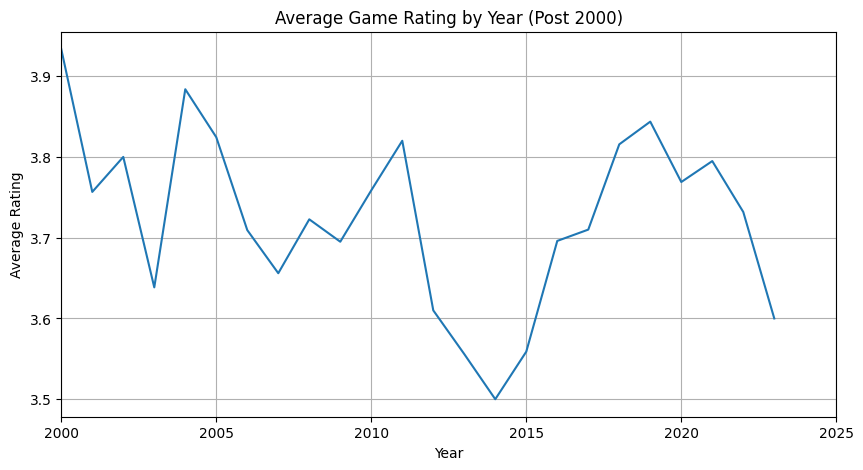

In [23]:
# For this project, I am mainly interested in games that released after the year 2000. I will filter the dataframe to target this timeframe.

filtered_popular_df = popular_df[popular_df["Year"] >= 2000]
filtered_popular_df.groupby("Year")["Rating"].mean().plot(figsize=(10, 5))
plt.title("Average Game Rating by Year (Post 2000)")
plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.xlim(2000, filtered_popular_df["Year"].max())
plt.grid(True)
plt.show()


This plot shows that the ratings swing noticeably from 2000 to 2011, with several highs and lows. There's a sharp drop around 2012, hitting a low point around 2014. Ratings recover steadily through 2019, but then drop through 2023.

To understand why there is a decline, let's investigate the genres and how they are rated.

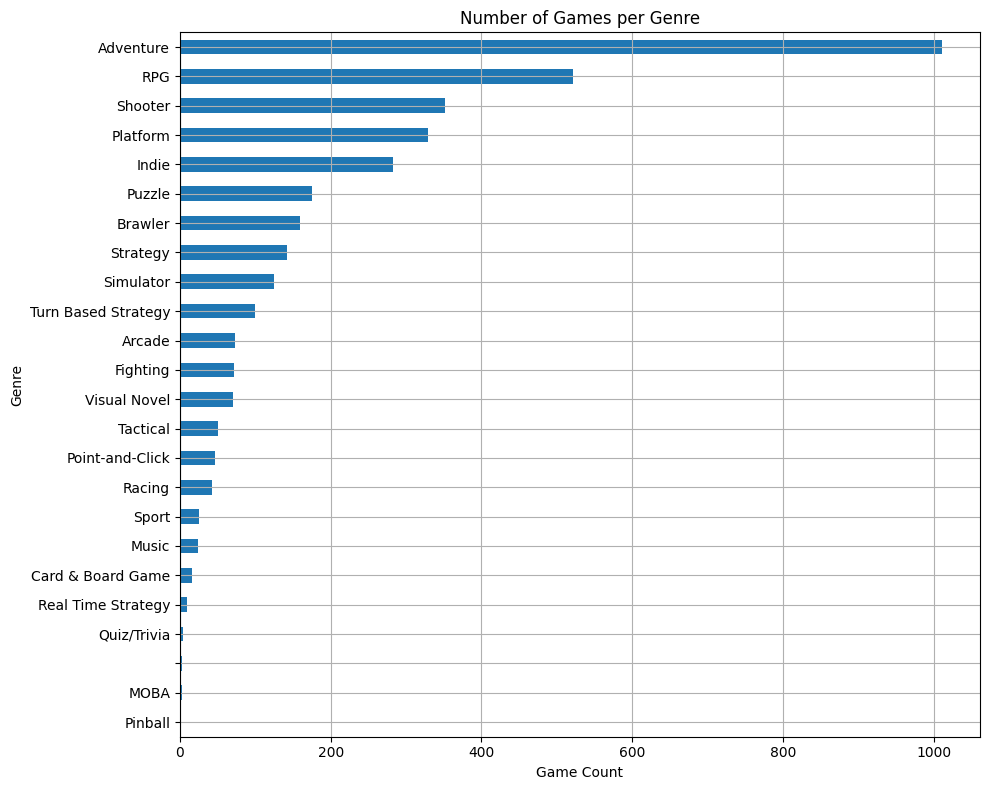

In [24]:
# Before we look at genres vs ratings, let's look at what the top genres are.

# First, we need to clean the genre strings and split into list
genre_lists = (
    popular_df["Genres"]
    .dropna()
    .astype(str)
    .str.replace("[\[\]']", "", regex=True)  # remove brackets and quotes
    .str.split(",")
    .apply(lambda x: [genre.strip() for genre in x])
)

# Next, we merge all genre entries into one list
all_genres = sum(genre_lists, [])
genre_counts = Counter(all_genres)
genre_counts_df = pd.DataFrame.from_dict(genre_counts, orient="index", columns=["Count"])

# Finally, we plot the dataframe from the genre_counts dictionary
genre_counts_df = genre_counts_df.sort_values("Count", ascending=True)\
    .plot(kind="barh", figsize=(10, 8), legend=False)

plt.title("Number of Games per Genre")
plt.xlabel("Game Count")
plt.ylabel("Genre")
plt.grid(True)
plt.tight_layout()
plt.show()


From the plot, we can see that only about 20 genres have more than a handful of games. To prevent misleading averages, I’ll filter out genres with very few entries before analyzing their ratings.

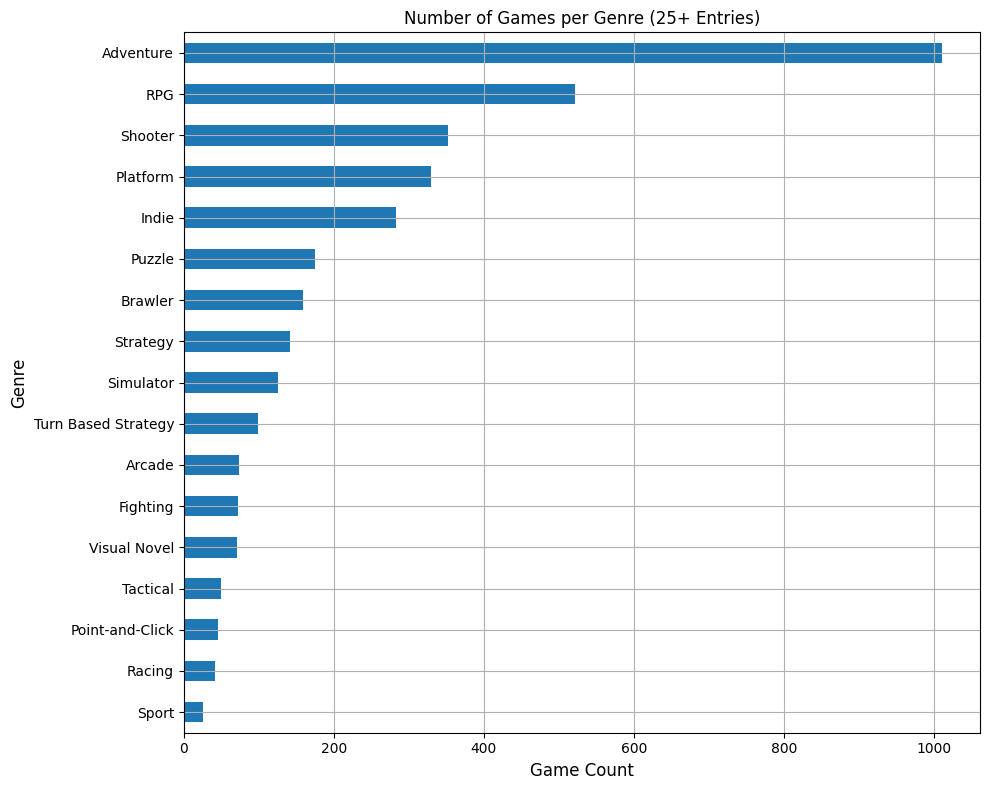

In [25]:
# Filtering to genres with 25 or more games
genre_counts_df = pd.DataFrame.from_dict(genre_counts, orient="index", columns=["Count"])
genre_counts_top20_df = genre_counts_df[genre_counts_df["Count"] >= 25]

genre_counts_top20_df = genre_counts_top20_df.sort_values("Count", ascending=True)\
    .plot(kind="barh", figsize=(10, 8), legend=False)

plt.title("Number of Games per Genre (25+ Entries)")
plt.xlabel("Game Count", fontsize=12)
plt.ylabel("Genre", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

Let's now work with these filtered genres.

It's important to note that although I removed genres with minimal game counts, there are still many genres with relatively few entries. Their ratings should be interpreted with a bit more caution, since they do not have nearly as much data as genres such as Adventure or RPG.

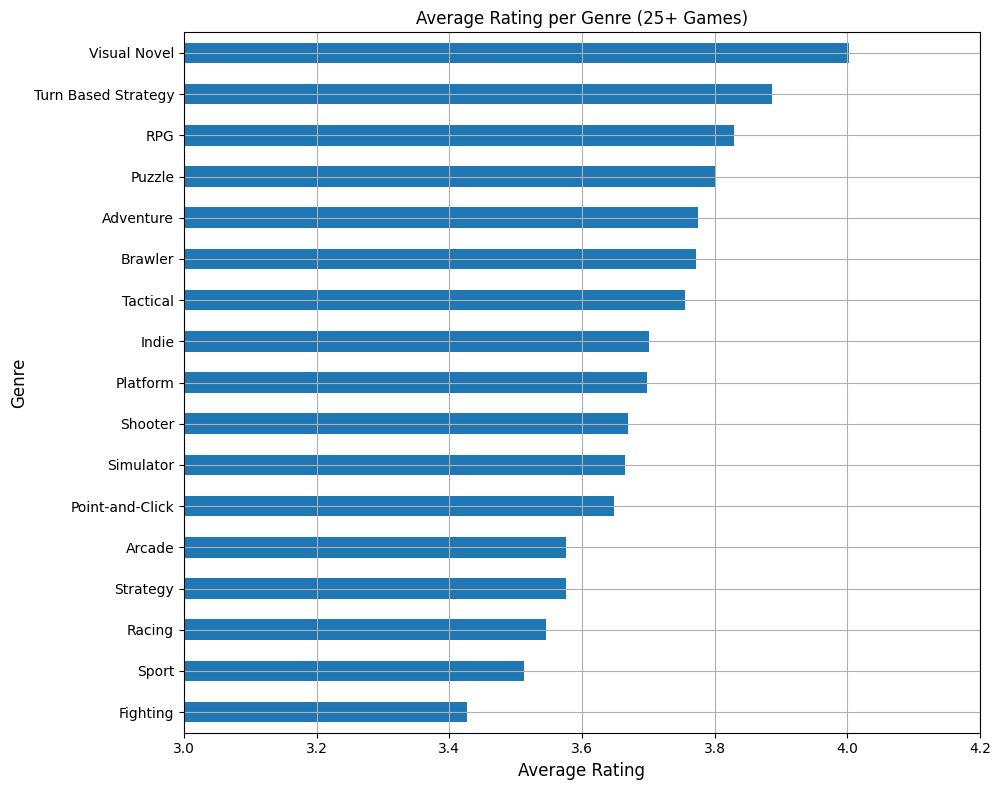

In [26]:
# Filter out rows with missing ratings
valid_df = popular_df[popular_df["Rating"].notna()]
valid_genre_lists = genre_lists[valid_df.index]

# Build a list of ratings for each genre, only if that genre has 25+ games
genre_ratings = defaultdict(list)

for genres, rating in zip(valid_genre_lists, valid_df["Rating"]):
    for genre in genres:
        if genre_counts_df.loc[genre, "Count"] >= 25:
            genre_ratings[genre].append(rating)

# Find the average rating for each genre
avg_ratings = {
    genre: sum(ratings) / len(ratings)
    for genre, ratings in genre_ratings.items()
}

# Save the results to a dataframe in case it needs to be reused
avg_genre_ratings_df = pd.DataFrame.from_dict(avg_ratings, orient="index", columns=["Average Rating"])
avg_genre_ratings_df = avg_genre_ratings_df.sort_values("Average Rating", ascending=True)

# Plot the average ratings per genre
avg_genre_ratings_df.plot(kind="barh", figsize=(10, 8), legend=False)
plt.title("Average Rating per Genre (25+ Games)")
plt.xlabel("Average Rating", fontsize=12)
plt.ylabel("Genre", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.xlim(3.0, 4.2)
plt.show()


After comparing the "Average Rating per Genre (25+ Games)" plot with the "Number of Games per Genre (25+ Entries)" plot, I have a few observations.

Visual Novels have the highest average rating of any genre in the dataset, despite having fewer than 100 games total. The reason they’re usually well-received could be because they focus more on story, character writing, and emotional appeal, and maybe because they’re made for a smaller or more specific audience. It’s also possible that fewer low-effort visual novels make it into the dataset compared to bigger genres.

Turn-Based Strategy is similar. It has a high rating and relatively few games. These types of games are harder to produce quickly and usually need more design and balance work, which might be why the quality stays more consistent.

RPGs and Puzzle games are also rated highly, but with more entries. That makes those results more trustworthy, since they represent a wider range of games and players. It also shows that these genres can stay consistent even at larger scales.

Adventure is the most common genre in the entire dataset, with over 1000 games. That being said, its average rating is noticeably lower. A likely reason could be that the genre has become saturated with low-effort or low-budget titles, particularly in the last decade. While standout titles like Breath of the Wild, Elden Ring, and Horizon Zero Dawn were crafted with care and creativity, many newer games seem driven purely by monetization. The rise of battle passes, cosmetic shops, and live-service models has shifted the focus from quality to revenue. Even though great adventure games are still being made, they’re often lost in a flood of releases that exist more to generate profit than to offer a meaningful experience.

Fighting, Sports, and Racing are consistently rated lower and also show up fairly often. These genres might suffer from franchise fatigue or a lack of innovation. There could also be more mobile-style or asset-flip games in these categories.

In general, the data suggests that less common, slower-paced, or more narrative-focused genres tend to score higher, while broader, more commercially targeted genres tend to average lower.